*This recap of Deep Learning Chapter 6.2 reveals the fundamental connection between probabilistic assumptions and the loss functions we use to train neural networks.*

📓 **For a deeper dive with additional exercises and analysis**, see the [complete notebook on GitHub](https://github.com/ickma2311/foundations/blob/main/deep_learning/chapter6/6.2/exercises.ipynb).

## The Hidden Connection: Why These Loss Functions?

Ever wondered why we use mean squared error for regression, cross-entropy for classification, and other specific loss functions? The answer lies in **maximum likelihood estimation** - each common loss function corresponds to the negative log-likelihood of a specific probabilistic model.

| **Probabilistic Model** | **Loss Function** | **Use Case** |
|-------------------------|-------------------|---------------|
| Gaussian likelihood | Mean Squared Error | Regression |
| Bernoulli likelihood | Binary Cross-Entropy | Binary Classification |
| Categorical likelihood | Softmax Cross-Entropy | Multiclass Classification |

## 🎯 Exploring the Connection: Probabilistic Models → Loss Functions

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Connection 1: Gaussian Likelihood → Mean Squared Error

**The Setup**: When we assume our targets have Gaussian noise around our predictions:

$$p(y|x) = \mathcal{N}(y; \hat{y}, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(y-\hat{y})^2}{2\sigma^2}\right)$$

**The Derivation**: Taking negative log-likelihood:

$$-\log p(y|x) = \frac{(y-\hat{y})^2}{2\sigma^2} + \frac{1}{2}\log(2\pi\sigma^2)$$

**The Result**: Minimizing this is equivalent to minimizing MSE (the constant term doesn't affect optimization)!

In [2]:
# Demonstrate Gaussian likelihood = MSE connection
np.random.seed(0)
x = np.linspace(-1, 1, 20)
y_true = 2 * x + 1
y = y_true + np.random.normal(0, 0.1, size=x.shape)  # Gaussian noise

# Simple linear model predictions
w, b = 1.0, 0.0
y_pred = w * x + b

# Compute MSE
mse = np.mean((y - y_pred)**2)

# Compute Gaussian negative log-likelihood
sigma_squared = 0.1**2
quadratic_term = 0.5 * np.mean((y - y_pred)**2) / sigma_squared
const_term = 0.5 * np.log(2 * np.pi * sigma_squared)
nll_gaussian = quadratic_term + const_term

print("📊 Gaussian Likelihood ↔ MSE Connection")
print("=" * 45)
print(f"📈 Mean Squared Error:     {mse:.6f}")
print(f"📊 Gaussian NLL:           {nll_gaussian:.6f}")
print(f"   ├─ Quadratic term:      {quadratic_term:.6f}")
print(f"   └─ Constant term:       {const_term:.6f}")

scaling_factor = 1 / (2 * sigma_squared)
print(f"\n🔗 Mathematical Connection:")
print(f"   Quadratic term = {scaling_factor:.1f} × MSE")
print(f"   {quadratic_term:.6f} = {scaling_factor:.1f} × {mse:.6f}")
print(f"\n✅ Minimizing MSE ≡ Maximizing Gaussian likelihood")

📊 Gaussian Likelihood ↔ MSE Connection
📈 Mean Squared Error:     1.450860
📊 Gaussian NLL:           71.159339
   ├─ Quadratic term:      72.542985
   └─ Constant term:       -1.383647

🔗 Mathematical Connection:
   Quadratic term = 50.0 × MSE
   72.542985 = 50.0 × 1.450860

✅ Minimizing MSE ≡ Maximizing Gaussian likelihood


## Connection 2: Bernoulli Likelihood → Binary Cross-Entropy

**The Setup**: For binary classification, we assume Bernoulli-distributed targets:

$$p(y|x) = \sigma(z)^y (1-\sigma(z))^{1-y}$$

where $\sigma(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function.

**The Derivation**: Taking negative log-likelihood:

$$-\log p(y|x) = -y\log\sigma(z) - (1-y)\log(1-\sigma(z))$$

**The Result**: This is exactly binary cross-entropy loss!

In [3]:
# Demonstrate Bernoulli likelihood = Binary cross-entropy connection
z = torch.tensor([-0.5, -0.8, 0.0, 0.8, 0.5])  # Model logits
y = torch.tensor([0.0, 0.0, 1.0, 1.0, 1.0])     # Binary labels
p = torch.sigmoid(z)  # Convert to probabilities

print("🎲 Bernoulli Likelihood ↔ Binary Cross-Entropy")
print("=" * 50)
print("Input Data:")
print(f"   Logits:        {z.numpy()}")
print(f"   Labels:        {y.numpy()}")
print(f"   Probabilities: {p.numpy()}")

# Manual Bernoulli NLL computation
bernoulli_nll = torch.mean(-(y * torch.log(p) + (1 - y) * torch.log(1 - p)))

# PyTorch binary cross-entropy
bce_loss = F.binary_cross_entropy(p, y)

print(f"\n📊 Loss Function Comparison:")
print(f"   Manual Bernoulli NLL:  {bernoulli_nll:.6f}")
print(f"   PyTorch BCE Loss:      {bce_loss:.6f}")

# Verify they're identical
difference = torch.abs(bernoulli_nll - bce_loss)
print(f"\n🔗 Verification:")
print(f"   Absolute difference:   {difference:.10f}")
print(f"\n✅ Binary cross-entropy IS Bernoulli negative log-likelihood!")

🎲 Bernoulli Likelihood ↔ Binary Cross-Entropy
Input Data:
   Logits:        [-0.5 -0.8  0.   0.8  0.5]
   Labels:        [0. 0. 1. 1. 1.]
   Probabilities: [0.37754068 0.3100255  0.5        0.6899745  0.62245935]

📊 Loss Function Comparison:
   Manual Bernoulli NLL:  0.476700
   PyTorch BCE Loss:      0.476700

🔗 Verification:
   Absolute difference:   0.0000000000

✅ Binary cross-entropy IS Bernoulli negative log-likelihood!


## Connection 3: Categorical Likelihood → Softmax Cross-Entropy

**The Setup**: For multiclass classification, we use the categorical distribution:

$$p(y=i|x) = \frac{e^{z_i}}{\sum_j e^{z_j}} = \text{softmax}(z)_i$$

**The Derivation**: Taking negative log-likelihood:

$$-\log p(y|x) = -\log \frac{e^{z_y}}{\sum_j e^{z_j}} = -z_y + \log\sum_j e^{z_j}$$

**The Result**: This is exactly softmax cross-entropy loss!

In [4]:
# Demonstrate Categorical likelihood = Softmax cross-entropy connection
z = torch.tensor([[0.1, 0.2, 0.7],    # Sample 1: class 2 highest
                  [0.1, 0.7, 0.2],    # Sample 2: class 1 highest  
                  [0.7, 0.1, 0.2]])   # Sample 3: class 0 highest

y = torch.tensor([2, 1, 0])           # True class indices

print("🎯 Categorical Likelihood ↔ Softmax Cross-Entropy")
print("=" * 55)
print("Input Data:")
print(f"   Logits shape:    {z.shape}")
print(f"   True classes:    {y.numpy()}")

# Convert to probabilities
softmax_probs = F.softmax(z, dim=1)
print(f"\nSoftmax Probabilities:")
for i, (logit_row, prob_row, true_class) in enumerate(zip(z, softmax_probs, y)):
    print(f"   Sample {i+1}: {prob_row.numpy()} → Class {true_class}")

# Manual categorical NLL (using log-softmax for numerical stability)
log_softmax = F.log_softmax(z, dim=1)
categorical_nll = -torch.mean(log_softmax[range(len(y)), y])

# PyTorch cross-entropy
ce_loss = F.cross_entropy(z, y)

print(f"\n📊 Loss Function Comparison:")
print(f"   Manual Categorical NLL: {categorical_nll:.6f}")
print(f"   PyTorch Cross-Entropy:  {ce_loss:.6f}")

# Verify they're identical
difference = torch.abs(categorical_nll - ce_loss)
print(f"\n🔗 Verification:")
print(f"   Absolute difference:    {difference:.10f}")
print(f"\n✅ Cross-entropy IS categorical negative log-likelihood!")

🎯 Categorical Likelihood ↔ Softmax Cross-Entropy
Input Data:
   Logits shape:    torch.Size([3, 3])
   True classes:    [2 1 0]

Softmax Probabilities:
   Sample 1: [0.25462854 0.28140804 0.46396342] → Class 2
   Sample 2: [0.25462854 0.46396342 0.28140804] → Class 1
   Sample 3: [0.46396342 0.25462854 0.28140804] → Class 0

📊 Loss Function Comparison:
   Manual Categorical NLL: 0.767950
   PyTorch Cross-Entropy:  0.767950

🔗 Verification:
   Absolute difference:    0.0000000000

✅ Cross-entropy IS categorical negative log-likelihood!


## Why This Matters: BCE vs MSE for Classification

Understanding the probabilistic foundation explains why binary cross-entropy works better than MSE for classification, even though both can theoretically solve binary problems.

**Key Differences:**
- **BCE gradient**: $\sigma(z) - y$ (simple, well-behaved)
- **MSE gradient**: $2(\sigma(z) - y) \times \sigma(z) \times (1 - \sigma(z))$ (can vanish!)

Let's see this in practice:

In [5]:
import torch.nn as nn
import torch.optim as optim

# Create synthetic binary classification data
torch.manual_seed(0)
X = torch.randn(100, 2)
y = (X[:, 0] + X[:, 1] > 0).float()  # Binary labels

print("🔥 BCE vs MSE Training Comparison")
print("=" * 40)
print("Dataset Information:")
print(f"   Total samples:     {len(X)}")
print(f"   Feature dimension: {X.shape[1]}")
print(f"   Positive class:    {y.sum().item():.0f} samples")
print(f"   Negative class:    {(1-y).sum().item():.0f} samples")

# Train with BCE (theoretically correct)
print(f"\n🎯 Training with Binary Cross-Entropy...")
model_bce = nn.Linear(2, 1)
loss_fn_bce = nn.BCEWithLogitsLoss()
optimizer_bce = optim.SGD(model_bce.parameters(), lr=0.1)

losses_bce = []
for epoch in range(20):
    optimizer_bce.zero_grad()
    logits = model_bce(X).squeeze()
    loss = loss_fn_bce(logits, y)
    loss.backward()
    optimizer_bce.step()
    losses_bce.append(loss.item())

# Train with MSE (suboptimal choice)
print(f"📈 Training with Mean Squared Error...")
model_mse = nn.Linear(2, 1)
loss_fn_mse = nn.MSELoss()
optimizer_mse = optim.SGD(model_mse.parameters(), lr=0.1)

losses_mse = []
for epoch in range(20):
    optimizer_mse.zero_grad()
    logits = model_mse(X).squeeze()
    probs = torch.sigmoid(logits)
    loss = loss_fn_mse(probs, y)
    loss.backward()
    optimizer_mse.step()
    losses_mse.append(loss.item())

# Compare final performance
with torch.no_grad():
    pred_bce = (torch.sigmoid(model_bce(X)) > 0.5).float()
    pred_mse = (torch.sigmoid(model_mse(X)) > 0.5).float()
    
    acc_bce = (pred_bce.squeeze() == y).float().mean()
    acc_mse = (pred_mse.squeeze() == y).float().mean()

print(f"\n📊 Final Performance Comparison:")
print(f"   BCE Accuracy:  {acc_bce:.4f} ({acc_bce*100:.1f}%)")
print(f"   MSE Accuracy:  {acc_mse:.4f} ({acc_mse*100:.1f}%)")

improvement = (acc_bce - acc_mse) / acc_mse * 100 if acc_mse > 0 else float('inf')
print(f"\n🚀 BCE Performance:")
if improvement > 0:
    print(f"   {improvement:.1f}% better than MSE")
else:
    print(f"   Similar to MSE performance")
    
print(f"\n✅ Key Insight: BCE provides better optimization dynamics for classification!")

🔥 BCE vs MSE Training Comparison
Dataset Information:
   Total samples:     100
   Feature dimension: 2
   Positive class:    54 samples
   Negative class:    46 samples

🎯 Training with Binary Cross-Entropy...


📈 Training with Mean Squared Error...

📊 Final Performance Comparison:
   BCE Accuracy:  0.6400 (64.0%)
   MSE Accuracy:  0.5000 (50.0%)

🚀 BCE Performance:
   28.0% better than MSE

✅ Key Insight: BCE provides better optimization dynamics for classification!


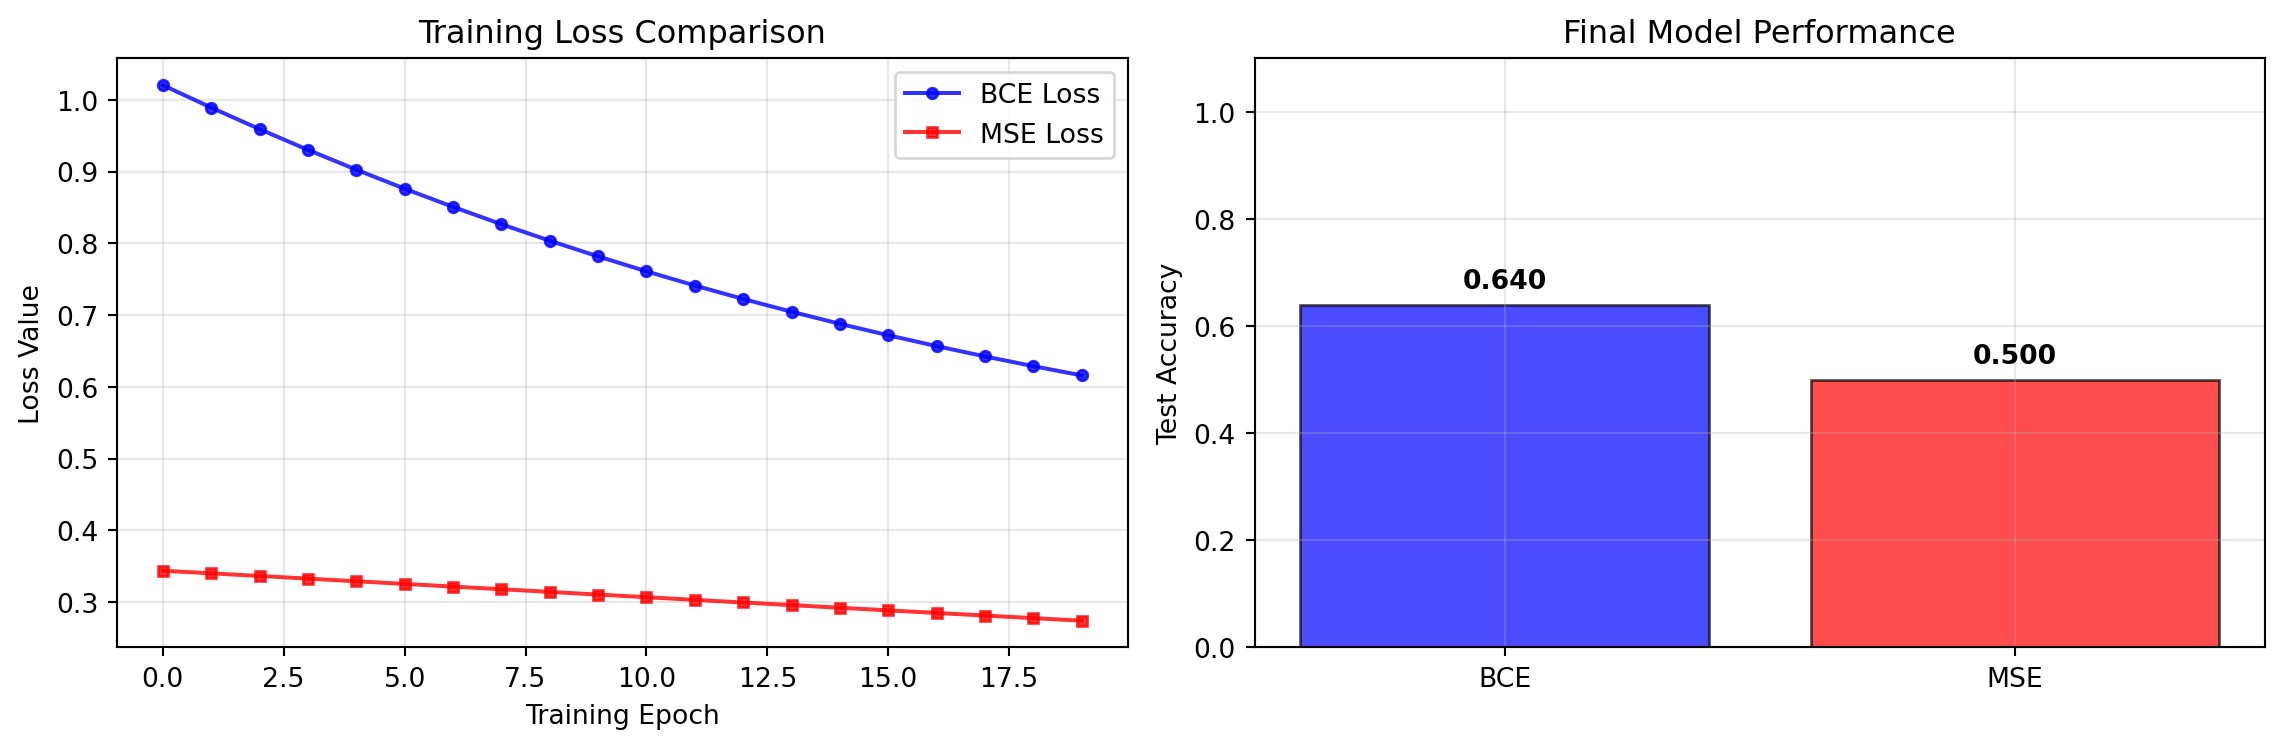

In [6]:
# Visualize training comparison
plt.figure(figsize=(12, 4))

# Training loss curves
plt.subplot(1, 2, 1)
plt.plot(range(20), losses_bce, 'b-o', label='BCE Loss', markersize=4, alpha=0.8)
plt.plot(range(20), losses_mse, 'r-s', label='MSE Loss', markersize=4, alpha=0.8)
plt.xlabel('Training Epoch')
plt.ylabel('Loss Value')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Final accuracy comparison
plt.subplot(1, 2, 2)
bars = plt.bar(['BCE', 'MSE'], [acc_bce.item(), acc_mse.item()], 
               color=['blue', 'red'], alpha=0.7, edgecolor='black')
plt.ylabel('Test Accuracy')
plt.title('Final Model Performance')
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3)

# Add accuracy labels
for bar, acc in zip(bars, [acc_bce.item(), acc_mse.item()]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()